This notebook is useful for creating reports for outside SQUID users. It reads in files and creates `magnetopy.QDFile` objects, which are then used to create:
 - figures (using plotting functionos found in `magnetopy.plot`)
 - a csv summarizing the important magnetic data (sample info, Msat, chi_max, etc.)
 - files containing simplified versions of the magnetometry data (removing unnecessary columns and header info from the .rw files and reported magnetization as mass corrected)

One area for improvement is the actual .doc/.pdf report creation, which is currently manually made by copying old report docx files. There are Python packages for doing this. 

In [1]:
import os
import pathlib
from typing import List
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys

import magnetopy as mp

%matplotlib inline

In [2]:
sample_name = "sample_id"
parent_folder = pathlib.Path(".") / "example_dir" / sample_name
files = list((parent_folder / "qd_files").glob("*[!.rw].dat"))
figure_folder = parent_folder / "figures"
simplified_data_folder = parent_folder / "simplified_data"
if not figure_folder.is_dir():
    figure_folder.mkdir(parents=True)
if not simplified_data_folder.is_dir():
    simplified_data_folder.mkdir(parents=True)


for i, file in enumerate(files):
    qdfile = mp.QDFile(file)
    print(f"[{i}] \t {qdfile.comments} \t {file.name}")

[0] 	 [] 	 101022.dat
[1] 	 ['ZFC, 100'] 	 101022_00001.dat
[2] 	 ['FC, 100'] 	 101022_00002.dat
[3] 	 ['ZFC, 1000'] 	 101022_00003.dat
[4] 	 ['FC, 1000'] 	 101022_00004.dat
[5] 	 ['MvsH, 20 C'] 	 101022_00006.dat


In [3]:
# check the indices above before assigning files to variables
zfc_100 = mp.QDFile(files[1])
fc_100 = mp.QDFile(files[2])
zfc_1000 = mp.QDFile(files[3])
fc_1000 = mp.QDFile(files[4])
mvsh_20 = mp.QDFile(files[5])

measurements = [
    zfc_100,
    fc_100,
    zfc_1000,
    fc_1000,
    mvsh_20,
]

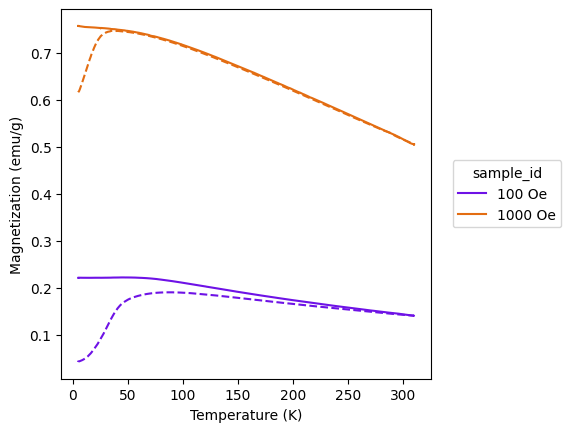

In [4]:
fname = figure_folder / "zfcfc.png"
fig, ax = mp.plot_zfcfc(
    [
        (zfc_100, fc_100),
        (zfc_1000, fc_1000),
    ],
    y_val="Moment_per_mass",
    labels=["100 Oe", "1000 Oe"],
    title=sample_name,
    save=fname,
)
plt.show()

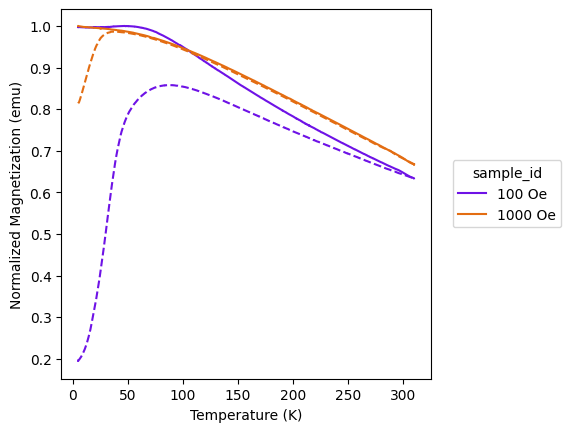

In [5]:
fname = figure_folder / "zfcfc_normalized.png"
fig, ax = mp.plot_zfcfc(
    [
        (zfc_100, fc_100),
        (zfc_1000, fc_1000),
    ],
    y_val="Moment_per_mass",
    labels=["100 Oe", "1000 Oe"],
    title=sample_name,
    normalized=True,
    save=fname,
)
plt.show()

The summary includes a .csv file with important values

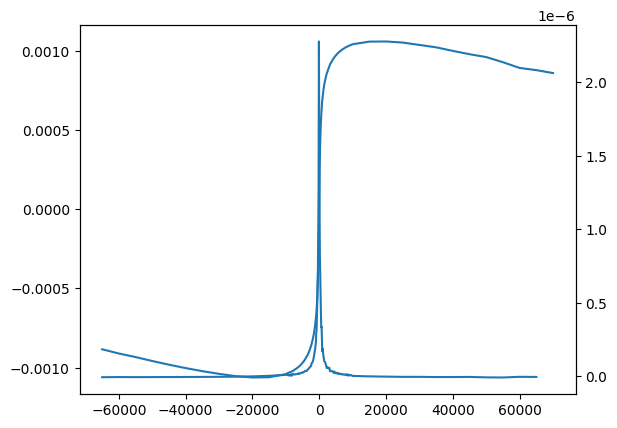

In [6]:
# create a csv file with a summary of the data
summary_csv_path = parent_folder / (sample_name + "_summary.csv")

zfc_100_T_maxM = zfc_100.parsed_data.loc[
    zfc_100.parsed_data["Moment_per_mass"].idxmax()
]["Temperature (K)"]
zfc_1000_T_maxM = zfc_1000.parsed_data.loc[
    zfc_1000.parsed_data["Moment_per_mass"].idxmax()
]["Temperature (K)"]

# determine max M (M_sat substitute given curvature)
msat = mvsh_20.parsed_data["Moment_per_mass"].max()
# graphically finding Hc
mvsh = pd.DataFrame()
mvsh["field"] = mvsh_20.parsed_data["Magnetic Field (Oe)"]
mvsh["moment"] = mvsh_20.parsed_data["DC Moment Free Ctr (emu)"]
mvsh["direction"] = mvsh["field"].diff()
mvsh = mvsh[mvsh["direction"] > 0]
hc = mvsh[mvsh["moment"] > 0]
hc = hc.reset_index(drop=True)
hc = hc["field"][0]
# if the field is basically zero, just report zero coercivity and assume
# the non-zero value is just the magnetometer not hitting zero exactly
if -2 < hc < 2:
    hc = 0
hc
# finding chi_max
mvsh = pd.DataFrame()
mvsh["field"] = mvsh_20.parsed_data["Magnetic Field (Oe)"]
mvsh["moment"] = mvsh_20.parsed_data["DC Moment Free Ctr (emu)"]
mvsh["direction"] = mvsh["field"].diff()
mvsh = mvsh[mvsh["direction"] > 0]
deriv = np.diff(mvsh["moment"]) / np.diff(mvsh["field"])
mvsh["deriv"] = np.append(deriv, np.nan)
# plot for a sanity check
fig, ax = plt.subplots()
ax.plot(mvsh["field"], mvsh["moment"])
ax2 = ax.twinx()
ax2.plot(mvsh["field"], mvsh["deriv"])
chi_max = mvsh["deriv"].max()


summary = [
    f"Name,{sample_name}\n",
    f"Mass (mg), {mvsh_20.sample_info.mass}\n",
    "\n",
    "[MAGNETIZATION VS TEMP]\n",
    "Field (Oe),T_B (max in ZFC) (T)\n",
    f'{zfc_100.parsed_data["Magnetic Field (Oe)"].unique()[0]}, {zfc_100_T_maxM}\n',
    f'{zfc_1000.parsed_data["Magnetic Field (Oe)"].unique()[0]}, {zfc_1000_T_maxM}\n',
    "\n",
    "[MAGNETIZATION VS FIELD]\n",
    "Temperature (C), M_sat (emu/g), H_c (Oe), chi_max (emu/g/Oe)\n",
    f'{mvsh_20.parsed_data["Temperature (K)"].unique()[0]-273.15},{msat},{hc},{chi_max}\n',
    "\n",
]

with open(summary_csv_path, "w") as f:
    for line in summary:
        f.writelines(line)

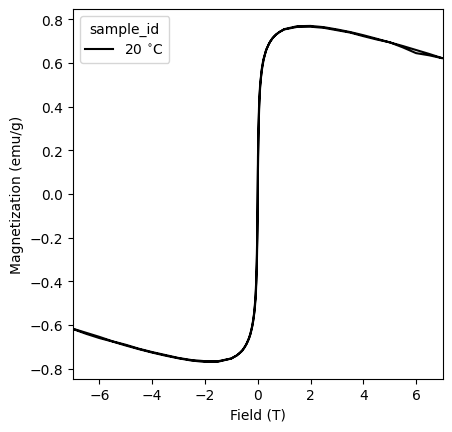

In [7]:
fname = figure_folder / "mvsh_20C.png"
mp.plot_mvsh(
    mvsh_20,
    y_val="Moment_per_mass",
    title=sample_name,
    labels="20 $^{\circ}$C",
    loc="upper left",
    xlim=(-7, 7),
    save=fname,
)
plt.show()

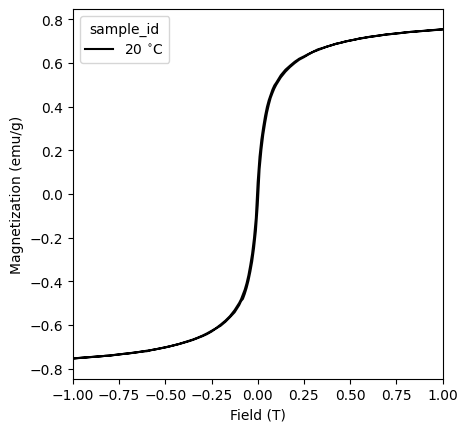

In [8]:
fname = figure_folder / "mvsh_20C_zoom.png"
mp.plot_mvsh(
    mvsh_20,
    y_val="Moment_per_mass",
    title=sample_name,
    labels="20 $^{\circ}$C",
    loc="upper left",
    xlim=(-1, 1),
    save=fname,
)
plt.show()

In addition to providing the (.rw).dat files in the report folder, the following code gives simplified files with only the important magnetic parameters. 

In [9]:
def write_simplified_data_file(
    data: mp.QDFile,
    columns: List[str],
    name: str,
    path: os.PathLike,
    filename: str,
    field: float | None = None,
    temperature: float | None = None,
):
    simple_df = pd.DataFrame()
    formatted_path = path / (name + "_" + filename + ".csv")
    for col in columns:
        if col == "Moment_per_mass":
            s_col = "Magnetic Moment (emu/g)"
        else:
            s_col = col
        simple_df[s_col] = data.parsed_data[col]
    simple_df.set_index(columns[0], inplace=True)
    simple_df.to_csv(formatted_path)

    csv_with_header = []
    with open(formatted_path, "r") as f:
        csv_with_header = f.readlines()
    header = [
        f"Name,{name}\n",
        f"Mass (mg),{data.sample_info.mass}\n",
        f"Magnetic Field (Oe),{field}\n",
        f"Temperature (K),{temperature}\n",
        "\n",
        "[DATA]\n",
    ]

    header.append(csv_with_header)
    with open(formatted_path, "w") as f:
        for line in header:
            f.writelines(line)

write_simplified_data_file(
    data=zfc_100,
    columns=["Temperature (K)", "Moment_per_mass"],
    name=sample_name,
    path= simplified_data_folder,
    filename="zfc_100Oe",
    field=zfc_100.parsed_data["Magnetic Field (Oe)"].unique()[0],
    temperature="",
)

write_simplified_data_file(
    data=fc_100,
    columns=["Temperature (K)", "Moment_per_mass"],
    name=sample_name,
    path= simplified_data_folder,
    filename="fc_100Oe",
    field=fc_100.parsed_data["Magnetic Field (Oe)"].unique()[0],
    temperature="",
)

write_simplified_data_file(
    data=zfc_1000,
    columns=["Temperature (K)", "Moment_per_mass"],
    name=sample_name,
    path= simplified_data_folder,
    filename="zfc_1000Oe",
    field=zfc_1000.parsed_data["Magnetic Field (Oe)"].unique()[0],
    temperature="",
)

write_simplified_data_file(
    data=fc_1000,
    columns=["Temperature (K)", "Moment_per_mass"],
    name=sample_name,
    path= simplified_data_folder,
    filename="fc_1000Oe",
    field=fc_1000.parsed_data["Magnetic Field (Oe)"].unique()[0],
    temperature="",
)

write_simplified_data_file(
    data=mvsh_20,
    columns=["Magnetic Field (Oe)", "Moment_per_mass"],
    name=sample_name,
    path= simplified_data_folder,
    filename="MvsH_20C",
    field="",
    temperature=mvsh_20.parsed_data["Temperature (K)"].unique()[0],
)